In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#machine learning inputs
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load in Data and make data cuts
- T-eff < 7000 to exclude high mass stars and most white dwarfs. 
- parallax > 1e-5
- G band Magnitude <18


In [2]:
# colnames = [
#     "starID",  #Assigned star ID
#     "Gaia", #Star ID from Gaia catalog
#     "Teff", #Effective temperature of the star (a derived quantity)
#     "e_Teff", #Error in effective temperature
#     "logg", #Log surface gravity
#     "e_logg", #error in surface gravity
#     "FeH", #Metallicity (ratio of iron to hydrogen)
#     "e_FeH", #error in metallicity
#     "Dist", #Distance to star
#     "e_Dist", #Error in distance to star
#     "Av", #Extintion of light along the line of sight 
#     "e_Av", #error in extinction
#     "Fbol", #Bolometric flux (integrated over all wavelengths)
#     "e_Fbol", #Error in bolometric flux
#     "angRad", #angular radius of star
#     "e_angRad", #Error in angular radius
#     "logL", #log bolometric luminosity
#     "e_logL", #error in log luminosity
#     "radius", #radius of the star
#     "e_radius", #error in radius
#     "npoint", #number of points in flux
#     "source", #target source
#     "ruwe", #Gaia weighted error
#     "RAdeg", #RA coordinate in degrees
#     "DEdeg", #DEC coordinate in degrees
#     "GLON", #galactic latitude
#     "GLAT", #galactic latitude
#     "Uniq", #is it a unique point
#     "BinarySource" #yes or no is it a binary source
# ]

#Data cleaning step already completed
# chunks = pd.read_csv("apjsacabc8t4_mrt.txt", names=colnames, sep=r"\s+", comment='#', engine='python', chunksize=50000)
# filtered_chunks=[]
# for chunk in chunks:
#     chunk = chunk[pd.to_numeric(chunk['Teff'], errors='coerce') < 9000]
#     chunk = chunk[chunk['Uniq'] == 'Y']
#     chunk = chunk.drop(['starID', 'Gaia', 'BinarySource', 'Uniq', 'ruwe', 'source'], axis=1)
#     chunk = chunk.apply(pd.to_numeric, errors='coerce')
#     chunk = chunk.dropna()
#     filtered_chunks.append(chunk)

# df = pd.concat(filtered_chunks)
# df.head()
# df.to_csv('GALAH_APOGEE_RAVE.csv', index=False)

In [3]:
df = pd.read_csv('GALAH_APOGEE_RAVE.csv')
df.head()

,Teff,e_Teff,logg,e_logg,FeH,e_FeH,Dist,e_Dist,Av,e_Av,...,e_angRad,logL,e_logL,radius,e_radius,npoint,RAdeg,DEdeg,GLON,GLAT
0,4226.1,141.9,4.62,0.07,-0.13,0.12,142.844,0.187,0.143,0.198,...,0.00158,-0.976,0.037,0.608,0.049,16.0,53.221178,-68.674790,284.403250,-42.173533
1,4908.7,171.8,2.32,0.08,-1.18,0.19,3483.971,100.874,0.112,0.160,...,0.00107,1.667,0.048,9.451,0.846,19.0,55.593978,-68.697933,283.721464,-41.476288
2,5560.0,153.3,4.07,0.06,0.02,0.10,800.286,10.866,0.149,0.118,...,0.00068,0.401,0.037,1.716,0.120,19.0,54.392074,-68.685000,284.059066,-41.833071
3,5623.7,156.4,4.28,0.06,-0.03,0.11,411.509,4.184,0.057,0.117,...,0.00103,0.190,0.037,1.315,0.092,19.0,55.770496,-68.722452,283.697372,-41.410086
4,6024.5,164.4,4.19,0.06,-0.35,0.15,549.269,10.376,0.078,0.107,...,0.00083,0.377,0.040,1.421,0.102,19.0,55.738304,-68.746178,283.732101,-41.405527


In [4]:
def get_Mbol(logLbol):
    Mbol = 71.19-(2.5*logLbol) #IAU 2015 definition
    return Mbol

Mbol_Yu = get_Mbol(df['logL'])

/mnt/c/Users/prera/Documents/GitHub/geology_final_project/geo_final/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


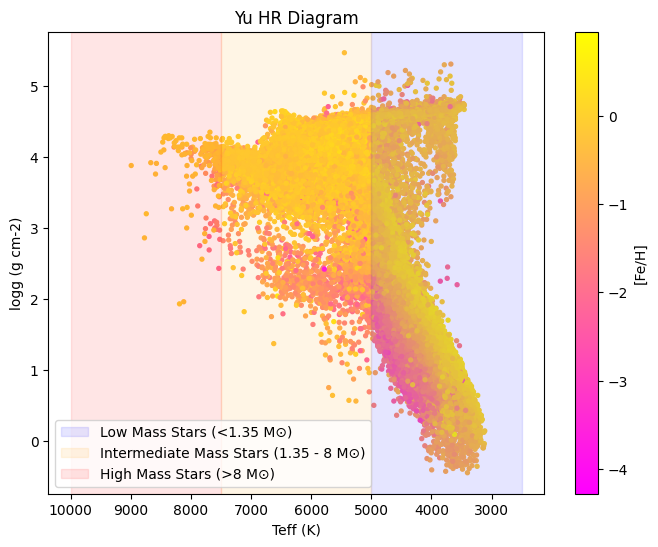

In [42]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(df['Teff'].iloc[::5], df['logg'].iloc[::5], c=df['FeH'].iloc[::5], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff (K)')
plt.ylabel("logg (g cm-2)")
plt.title("Yu HR Diagram")

#Hr diagram markers 
teff = df['Teff']
# Define mass boundaries (for example, in solar masses)
low_mass = (teff < 6550)  # Low mass stars have lower Teff (this is a rough example)
intermediate_mass = (teff >= 6550) & (teff < 7000)  # Intermediate mass
high_mass = (teff >= 7000)  # High mass stars

# Plot shaded regions for mass groups
plt.axvspan(2500, 5000, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(5000, 7500, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')
plt.axvspan(7500, 10000, color='red', alpha=0.1, label='High Mass Stars (>8 M⊙)')

# Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.savefig('Yu_HR.png', dpi=200)
plt.show()

In [ ]:
def clustering(nclust, X, true_labels):
    kmeans = KMeans(n_clusters=nclust, random_state=0, n_init="auto").fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Sort cluster labels by Teff (column 0)
    sorted_indices = np.argsort(centers[:, 0])
    label_mapping = {old: new for new, old in enumerate(sorted_indices)}
    labels = np.vectorize(label_mapping.get)(labels)

    # Downsample for plotting
    x_plot = X['Teff'].iloc[::5]
    y_plot = X['logL'].iloc[::5]

    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Scatter plots
    points = axs[0].scatter(x_plot, y_plot, c=labels[::5], s=4)
    misclassified = labels[::5] - true_labels[::5]
    points_misclass = axs[1].scatter(x_plot, y_plot, c=misclassified, s=4, cmap='Set1')

    # Add cluster centers
    for ax in axs:
        ax.scatter(centers[:, 0], centers[:, 4], marker='x', c='black', s=80, label='Centers')
        ax.set_title("Clustered HR Diagram")
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel(r'Bolometric Luminosity ($L_{\odot}$)')
        ax.invert_xaxis()
        ax.legend()

    # Plot spectral lines and labels
    spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
    teff_values = [7220, 6650, 5930, 5270, 3850]

    for ax in axs:
        y_top = ax.get_ylim()[1]
        for teff, label in zip(teff_values, spectral_types_break):
            ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
            y_offset = 0.3 if label != 'Kraft Break' else 1.2
            ax.text(teff, y_top - y_offset, label,
                    rotation=90 if label == 'Kraft Break' else 0,
                    verticalalignment='top',
                    horizontalalignment='center',
                    fontsize=9)

    # Add colorbars
    fig.colorbar(points, ax=axs[0], label='Cluster label')
    fig.colorbar(points_misclass, ax=axs[1], label='Label Difference')

    plt.tight_layout()
    plt.show()


In [ ]:
fitcolsT = [
    "Teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicity
    "Fbol", #Bolometric flux (integrated over all wavelengths)
    #"e_Fbol", #Error in bolometric flux
    #"angRad", #angular radius of star
    #"e_angRad", #Error in angular radius
    "logL", #log bolometric luminosity
    #"e_logL", #error in log luminosity
    "radius", #radius of the star
    #"e_radius", #error in radius
]
XT = df[fitcolsT]


masses = [
    df['Teff'] < 5000,
    (df['Teff'] >= 5000) & (df['Teff'] < 7500),
    df['Teff'] >= 7500
]
mass_labels = [0, 1, 2]

labels_3clust = np.select(masses, mass_labels)

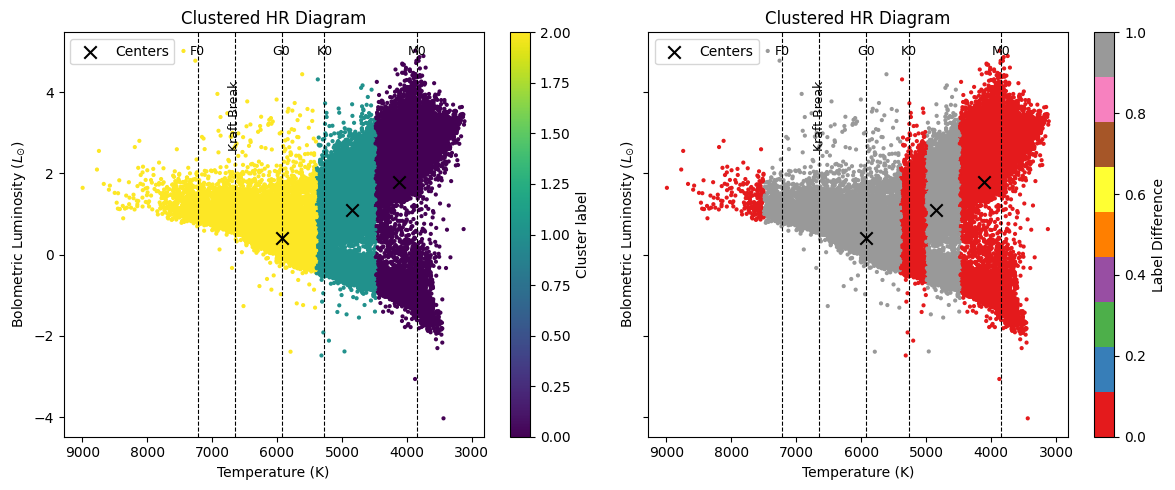

In [13]:
clustering(3, XT, labels_3clust)

In [16]:
# Define bin edges (midpoints between teff_values)
bin_edges = [float('inf'),  # for F0 and hotter
             (7220 + 6650)/2,
             (6650 + 5930)/2,
             (5930 + 5270)/2,
             (5270 + 3850)/2,
             float('-inf')]  # for M0 and cooler

# Reverse to go from hot → cool → cold
bin_edges = bin_edges[::-1]  # smallest to largest

# Corresponding spectral labels
spectral_labels = np.arange(5)

# Apply using np.select
conditions = [
    (df['Teff'] > bin_edges[i]) & (df['Teff'] <= bin_edges[i+1])
    for i in range(len(bin_edges) - 1)
]

labels_5clust = np.select(conditions, spectral_labels)


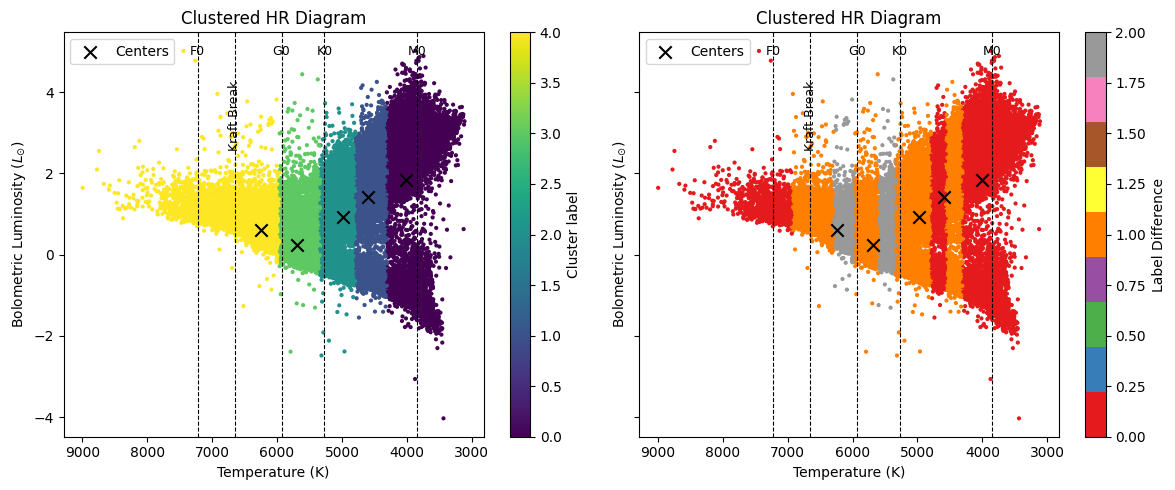

In [17]:
clustering(5, XT, labels_5clust)

It's interesting that despite not telling the algorithm anything about physics, it winds up with these vertical divisions based on temperature anyway. What happens when we take away Teff information?

# Confusion matrix

ConfusionMatrix [[202249 363389 216550      0      0]
 [     0      0 136675 315105 211144]
 [     0      0      0      0   1017]
 [     0      0      0      0      0]
 [     0      0      0      0      0]]


/mnt/c/Users/prera/Documents/GitHub/geology_final_project/geo_final/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/prera/Documents/GitHub/geology_final_project/geo_final/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/prera/Documents/GitHub/geology_final_project/geo_final/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

           0       1.00      0.26      0.41    782188
           1       0.00      0.00      0.00    662924
           2       0.00      0.00      0.00      1017
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.14   1446129
   macro avg       0.20      0.05      0.08   1446129
weighted avg       0.54      0.14      0.22   1446129



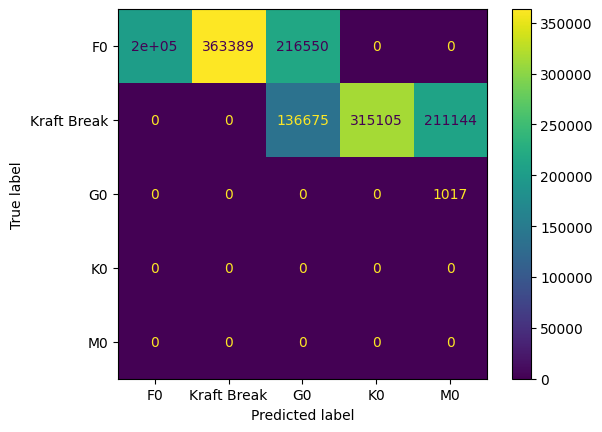

In [71]:
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
cm = confusion_matrix(df['label'],ordered_labelsT)
print("ConfusionMatrix",cm)
print(classification_report(df['label'],ordered_labelsT))
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot()
plt.show()

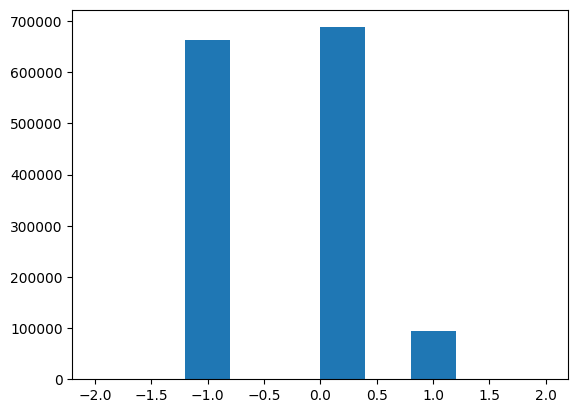

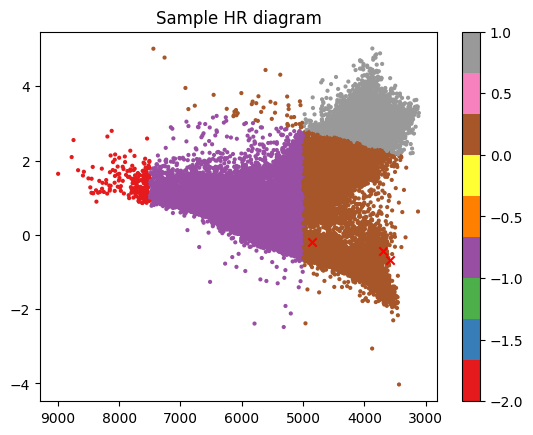

In [ ]:
fitcolsnT = [
    #"Teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicity
    #"Fbol", #Bolometric flux (integrated over all wavelengths)
    #"e_Fbol", #Error in bolometric flux
    "angRad", #angular radius of star
    #"e_angRad", #Error in angular radius
    "logL", #log bolometric luminosity
    #"e_logL", #error in log luminosity
    "radius", #radius of the star
    #"e_radius", #error in radius
]
XnT = df[fitcolsnT]
kmeansnT = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(XnT)
labelsnT = kmeansnT.labels_
centersnT = kmeansnT.cluster_centers_
#plt.hist(labelsnT-df['label'])
#plt.show()

Tidx = [np.argmin(np.abs(df['logg']-logg)) for logg in centersnT[:,0]]
Tcenters = df['Teff'].iloc[Tidx]
points1=plt.scatter(df['Teff'].iloc[::5], XnT['logL'].iloc[::5], c=labelsnT[::5]-df['label'].iloc[::5], s=4, cmap='Set1')
plt.scatter(Tcenters, centersnT[:,1], marker='x', c='r')
plt.colorbar(points1)
plt.gca().invert_xaxis()
plt.title("Sample HR diagram")
plt.show()

# PCA

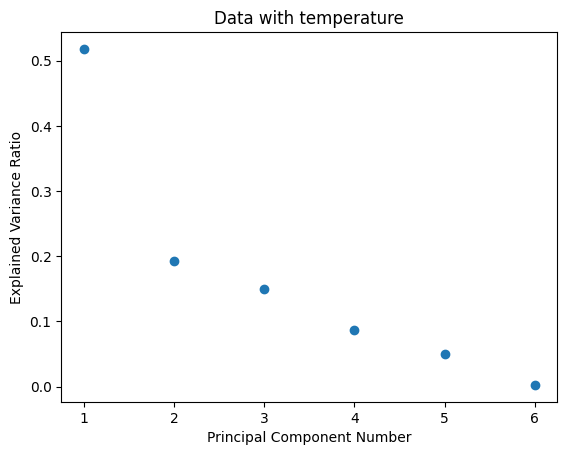

In [26]:
from sklearn.decomposition import PCA
df_norm = (XT - XT.mean()) / XT.std()
ncomp=6
pca = PCA(n_components=ncomp)
x_transform = pca.fit_transform(df_norm)
explained_variances = pca.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data with temperature')
plt.show()

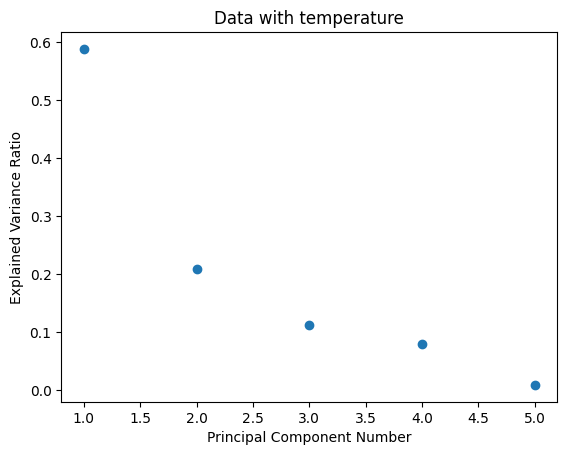

In [ ]:
from sklearn.decomposition import PCA
df_norm = (XnT - XnT.mean()) / XnT.std()
ncomp=5
pca = PCA(n_components=ncomp)
x_transform = pca.fit_transform(df_norm)
explained_variances = pca.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data without temperature')
plt.show()

# Supervised classification

In [36]:
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6650, 5930, 5270, 3850]

temp_bounds = [
    df['Teff'] < 3850,
    (df['Teff'] >= 3850) & (df['Teff'] < 5720),
    (df['Teff'] >= 5720) & (df['Teff'] < 5930),
    (df['Teff'] >= 5930) & (df['Teff'] < 6650),
    (df['Teff'] >= 6650) & (df['Teff'] < 7220),
    df['Teff'] >= 7220
]

mass_labels_reg = np.arange(6)

reg_df = df.copy()
reg_df['label'] = np.select(temp_bounds, mass_labels_reg)